<a href="https://colab.research.google.com/github/whddk4415/2020_cau_oss_hackathon/blob/master/hackathon_team04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 해커톤 진행 주의사항**

**1)  개발 관련 주의사항**
*   [1. 초기 환경 설정]은 절대 수정하지 말 것
*   모든 구현은 [2. 데이터 전처리] 및 [3.모델 생성]에서만 진행
*   [4. 모델 저장]에서 team_name 변수 변경 (예.`team_name = 'team01'`)
 *    트레이닝 중간에 checkpoint를 활용하여 모델을 저장한 경우에도 파일 이름 양식 통일 필수
*   Colab 사용중 실수로 데이터 손실이 발생할 수도 있으니 중간 결과값을 github에 업로드 
 *    "런타임->모든 런타임 재설정"은 절대 누르지 말 것 (저장한 모델 데이터가 모두 삭제됨)
*   효율적인 구현 및 테스팅을 위해 GPU 가속 기능 활성화
 *    "런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 설정"
*   주석을 최대한 자세히 작성
*   Keras API 관련하여 [Keras Documentation](https://keras.io/) 참조

**2) 제출 관련 주의사항**
*  제출물
 *  소스코드 (hackathon_teamXX.ipynb)
 *  컴파일된 모델 파일 (model_entire_teamXX.h5)
 *  모델 발표 자료 
* 제출 기한: **오후 5시 (단, 발표자료는 11시)**
* 제출 방법: [GitHub README](https://github.com/cauosshackathonta/2020_cau_oss_hackathon/) 참조

 
**3) 평가 관련 주의사항**
*  모델 성능 = 테스트 데이터 셋 분류 정확도
 *  model.evaluate(x_test, y_test)
*  제출된 모델들의 테스트 데이터 셋 분류 정확도를 기준으로 수상작 결정
*  수상 후보들에 대해서는 소스코드를 기반으로 모델 재검증 
 
**4) 수상 실격 사유**
*  유사한 소스코드 or 알고리즘이 적발될 경우
*  소스코드와 제출된 모델이 상이한 경우
*  개발 관련 주의사항을 지키지 않은 경우
 *  예: [초기 환경 설정]을 수정한 경우
*  데이터 셋을 변조한 경우
 *  예. 테스트 데이터 셋을 트레이닝 데이터 셋에 포함하여 모델 생성 
*  주석이 소스코드와 맞지 않거나 미비할 경우






# **1. 초기 환경 설정**



In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras 및 관련 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

import numpy as np

# 데이터셋 다운로드
check = !if [ -d 'dataset/' ]; then echo "1" ; else echo "0"; fi
if (check[0] is '0' ):
  !mkdir dataset
  !wget 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
  !unzip matlab.zip -d /content/dataset

# 데이터셋 로드
from scipy import io as spio
emnist = spio.loadmat("/content/dataset/matlab/emnist-balanced.mat")

x_train = emnist["dataset"][0][0][0][0][0][0]
y_train = emnist["dataset"][0][0][0][0][0][1]

x_test = emnist["dataset"][0][0][1][0][0][0]
y_test = emnist["dataset"][0][0][1][0][0][1]

# # 분류를 위해 클래스 벡터를 바이너리 매트릭스로 변환
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 데이터 28x28 이미지화
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# 총 클래스 개수
num_classes = y_test.shape[1]
input_shape = x_test.shape[1:]

In [78]:
print(input_shape)

(28, 28, 1)


# **2. 데이터 전처리**



In [66]:
# 데이터 전처리 (예: normalization)
x_train_after = x_train / 255.0
x_test_after = x_test / 255.0

In [33]:
import matplotlib.pyplot as plt

# 손실 그래프
def plot_loss(history):
	# 선 그리기
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	# 그래프 제목
	plt.title('Model Loss')
	# x,y축 이름 표시
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	# 각 라인 표식 표시
	plt.legend(['Train','Test'],loc=0)

# 정확도 그래프
def plot_acc(history):
  # dir(history.history)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('Model accuracy')
	plt.ylabel('Accuracy')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc=0)

In [42]:
print(x_train.shape)
print(x_test.shape)

(112800, 28, 28, 1)
(18800, 28, 28, 1)


# **3. 모델 생성**

In [123]:
inputs = tf.keras.layers.Input(input_shape)
dropout_rate = 0.5

net = tf.keras.layers.BatchNormalization()(inputs)
net = tf.keras.layers.Conv2D(128, (3, 3), padding='SAME')(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.Conv2D(128, (3, 3), padding='SAME')(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(net)
net = tf.keras.layers.Dropout(dropout_rate)(net)

net = tf.keras.layers.Conv2D(256, (3, 3), padding='SAME')(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.Conv2D(256, (3, 3), padding='SAME')(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))(net)
net = tf.keras.layers.Dropout(dropout_rate)(net)

net = tf.keras.layers.Flatten()(net)
net = tf.keras.layers.Dense(512)(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.Dropout(dropout_rate)(net)
net = tf.keras.layers.Dense(num_classes)(net)
net = tf.keras.layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='team04')


# 모델 컴파일
# optimizer: 모델을 업데이트 하는 방식
# loss: 모델의 정확도를 판단하는 방식
# metrics: 트레이닝 및 테스팅 성능 모니터링을 위한 평가지표
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# 체크포인트 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

# 모델 트레이닝
# batch_size: 전체 데이터셋 중 몇개씩 학습시킬 것인지
# epoch: 학습에 전체 데이터셋이 총 몇번 이용될 것인지
# shuffle: 학습전에 트레이닝 데이터셋을 랜덤하게 섞을 것인지
# validation_data: 중간 성능 검증에 사용할 data set
history = model.fit(x_train_after, y_train, batch_size = 100, epochs = 20, shuffle=True, callbacks=[cp_callback], validation_data=(x_test_after, y_test))

Epoch 1/20
1128/1128 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.7666WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_test_batch_end` time: 0.0107s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.86521, saving model to /content/checkpoint_entire_best.h5
1128/1128 [==============================] - 48s 43ms/step - loss: 0.7384 - accuracy: 0.7666 - val_loss: 0.3920 - val_accuracy: 0.8652
Epoch 2/20
1127/1128 [============================>.] - ETA: 0s - loss: 0.4524 - accuracy: 0.8427
Epoch 00002: val_accuracy improved from 0.86521 to 0.87191, saving model to /content/checkpoint_entire_best.h5
1128/1128 [==============================] - 48s 43ms/step - loss: 0.4523 - accuracy: 0.8427 - val_loss: 0.3525 - val_accuracy: 0.8719
Epoch 3/20
1128/1128 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8534
Epoch 00003: val_accuracy improved from 0.87

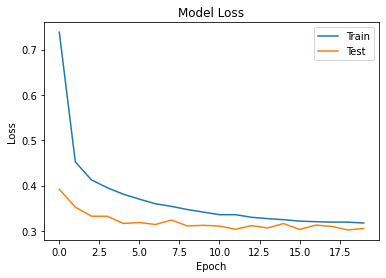

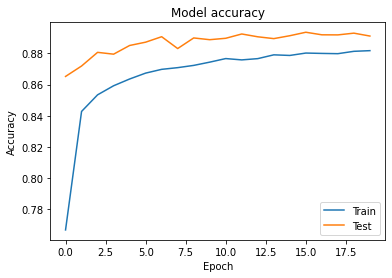

In [124]:
plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

# **4. 모델 저장**

In [125]:
save_path = '/content/'
team_name = 'team04'

# 트레이닝된 전체 모델을 저장합니다.
model.save(save_path +  'model_entire_'+ team_name + '.h5')

# **5. 모델 로드 및 평가**

In [128]:
save_path = '/content/'
team_name = 'team04'

model = keras.models.load_model(save_path + 'model_entire_' + team_name + '.h5')

model.evaluate(x_test_after, y_test)

588/588 [==============================] - 3s 6ms/step - loss: 0.3032 - accuracy: 0.8936


[0.3032320737838745, 0.8936170339584351]